Data shape: (13436, 5)
Number of classes: 10

Target distribution:
 LC_Kategori
Dil ve Edebiyat            3274
Tıp                        2703
Hukuk                      1016
Siyaset Bilimi             1001
Felsefe, Psikoloji, Din     965
Bilim                       957
Güzel Sanatlar              952
Eğitim                      913
Sosyal Bilimler             904
Diğerleri                   751
Name: count, dtype: int64

[Baseline] Training Logistic Regression...

===== Baseline - Logistic Regression =====
Accuracy: 0.7347470238095238
F1 macro: 0.6937609550966336

Classification report:
                          precision    recall  f1-score   support

                  Bilim       0.70      0.92      0.80       192
        Dil ve Edebiyat       0.90      0.30      0.45       655
              Diğerleri       0.00      0.00      0.00       150
                 Eğitim       0.76      0.92      0.83       183
Felsefe, Psikoloji, Din       0.65      0.93      0.77       193
         Güz

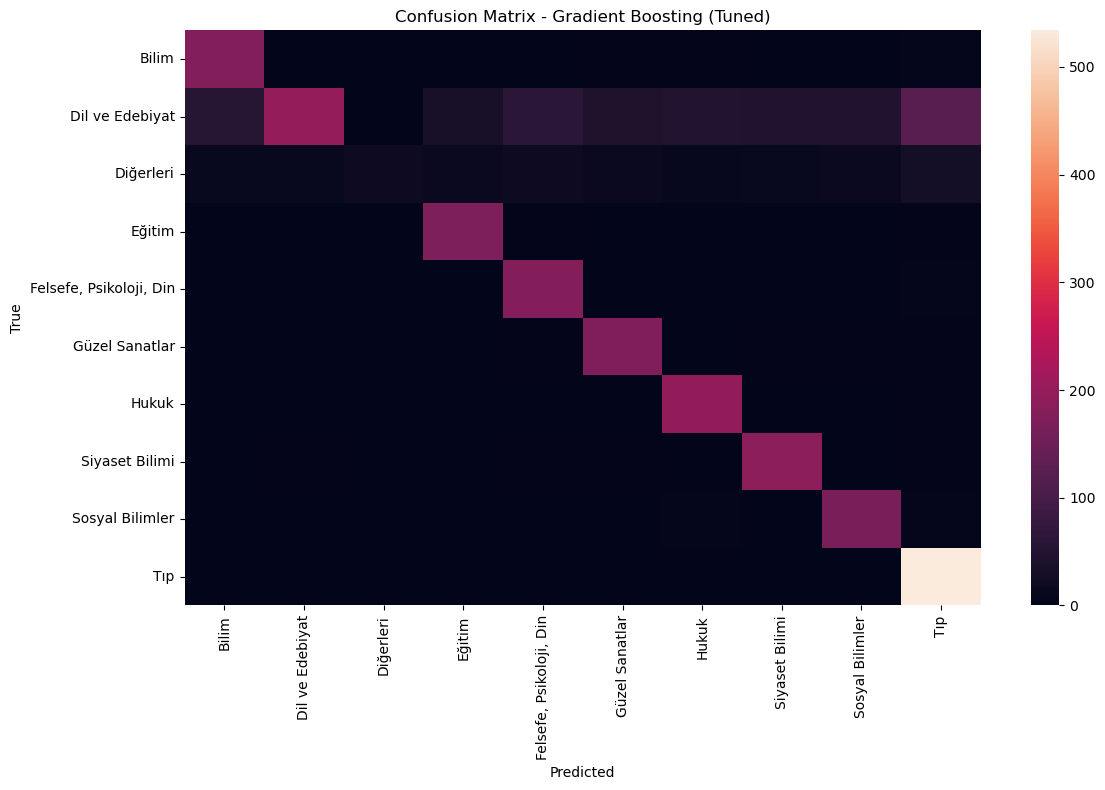

[GB] Saved: gradient_boosting_tuned_final.joblib

[ExtraTrees] Tuning started...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[ExtraTrees] Best params: {'model__n_estimators': 600, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 20, 'model__bootstrap': False}

===== Advanced 2 - Extra Trees (Tuned) =====
Accuracy: 0.7351190476190477
F1 macro: 0.6951522518236121

Classification report:
                          precision    recall  f1-score   support

                  Bilim       0.70      0.92      0.80       192
        Dil ve Edebiyat       0.90      0.30      0.45       655
              Diğerleri       1.00      0.01      0.01       150
                 Eğitim       0.76      0.92      0.83       183
Felsefe, Psikoloji, Din       0.65      0.93      0.77       193
         Güzel Sanatlar       0.71      0.91      0.80       190
                  Hukuk       0.73      0.97      0.83       203
         Siy

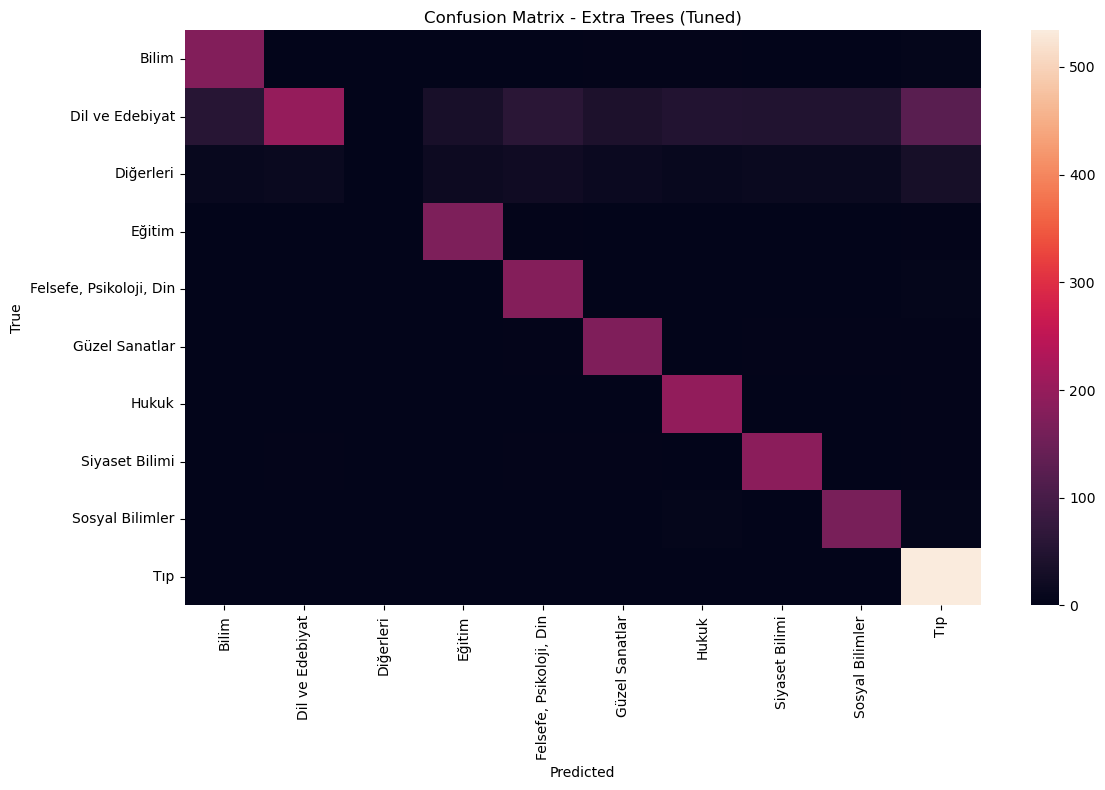

[ExtraTrees] Saved: extra_trees_tuned_final.joblib

===== Final Comparison (sorted by F1_macro) =====


,Model,Accuracy,F1_macro
1,Advanced - GradientBoosting (Tuned),0.741443,0.716829
2,Advanced - ExtraTrees (Tuned),0.735119,0.695152
0,Baseline - LogisticRegression,0.734747,0.693761



Done. Saved outputs:
 - cm_gradient_boosting_tuned.png
 - cm_extra_trees_tuned.png
 - baseline_logreg_final.joblib
 - gradient_boosting_tuned_final.joblib
 - extra_trees_tuned_final.joblib


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib



file_path = "SonHali_Kategorili_Liste.xlsx"
df = pd.read_excel(file_path)

target_col = "LC_Kategori"

if "ÖğrenciKimlik-no" in df.columns:
    df = df.drop(columns=["ÖğrenciKimlik-no"])

X = df.drop(columns=[target_col])
y = df[target_col]

print("Data shape:", df.shape)
print("Number of classes:", y.nunique())
print("\nTarget distribution:\n", y.value_counts())



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

def evaluate(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"\n===== {model_name} =====")
    print("Accuracy:", acc)
    print("F1 macro:", f1m)
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
    return acc, f1m

def plot_cm(title, y_true, y_pred, labels, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=False, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


labels_sorted = sorted(y.unique())
results = []



baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, multi_class="multinomial"))
])

print("\n[Baseline] Training Logistic Regression...")
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

base_acc, base_f1m = evaluate("Baseline - Logistic Regression", y_test, y_pred_base)
results.append({"Model": "Baseline - LogisticRegression", "Accuracy": base_acc, "F1_macro": base_f1m})

joblib.dump(baseline, "baseline_logreg_final.joblib")
print("[Baseline] Saved: baseline_logreg_final.joblib")



gb = GradientBoostingClassifier(random_state=42)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gb)
])

gb_params = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 5],
    "model__subsample": [0.8, 1.0]
}

gb_search = RandomizedSearchCV(
    gb_pipe,
    param_distributions=gb_params,
    n_iter=15,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n[GB] Tuning started...")
gb_search.fit(X_train, y_train)

best_gb = gb_search.best_estimator_
print("[GB] Best params:", gb_search.best_params_)

y_pred_gb = best_gb.predict(X_test)
gb_acc, gb_f1m = evaluate("Advanced 1 - Gradient Boosting (Tuned)", y_test, y_pred_gb)
results.append({"Model": "Advanced - GradientBoosting (Tuned)", "Accuracy": gb_acc, "F1_macro": gb_f1m})

plot_cm("Confusion Matrix - Gradient Boosting (Tuned)", y_test, y_pred_gb, labels_sorted, "cm_gradient_boosting_tuned.png")

joblib.dump(best_gb, "gradient_boosting_tuned_final.joblib")
print("[GB] Saved: gradient_boosting_tuned_final.joblib")



et = ExtraTreesClassifier(random_state=42, n_jobs=-1)

et_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", et)
])

et_params = {
    "model__n_estimators": [300, 600, 900],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [False, True]
}

et_search = RandomizedSearchCV(
    et_pipe,
    param_distributions=et_params,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n[ExtraTrees] Tuning started...")
et_search.fit(X_train, y_train)

best_et = et_search.best_estimator_
print("[ExtraTrees] Best params:", et_search.best_params_)

y_pred_et = best_et.predict(X_test)
et_acc, et_f1m = evaluate("Advanced 2 - Extra Trees (Tuned)", y_test, y_pred_et)
results.append({"Model": "Advanced - ExtraTrees (Tuned)", "Accuracy": et_acc, "F1_macro": et_f1m})

plot_cm("Confusion Matrix - Extra Trees (Tuned)", y_test, y_pred_et, labels_sorted, "cm_extra_trees_tuned.png")

joblib.dump(best_et, "extra_trees_tuned_final.joblib")
print("[ExtraTrees] Saved: extra_trees_tuned_final.joblib")



results_df = pd.DataFrame(results).sort_values(by="F1_macro", ascending=False)

print("\n===== Final Comparison (sorted by F1_macro) =====")
display(results_df)

print("\nDone. Saved outputs:")
print(" - cm_gradient_boosting_tuned.png")
print(" - cm_extra_trees_tuned.png")
print(" - baseline_logreg_final.joblib")
print(" - gradient_boosting_tuned_final.joblib")
print(" - extra_trees_tuned_final.joblib")